# Setup


In [0]:
# Mounting Google Drive locally
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Install Kaggle library
!pip install -q kaggle

In [0]:
# Storing Kaggle API token to /root/.kaggle/ 
%cd .. 

# Make kaggle folder 
!mkdir -p ~/.kaggle

# Change directory to newly created folder
import os
os.chdir("root/.kaggle/")

/


In [0]:
# Upload Kaggle API token (NOTE: this file needs to be downloaded manually on Kaggle)
from google.colab import files
token = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
# Changing permission for kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
# Navigate to project folder 
%cd ../../  
os.chdir("content/drive/My Drive/BOLT2019/")

In [0]:
# Downlaod data for the modified-mnist challenge
!kaggle datasets download -d wendykan/lending-club-loan-data

In [0]:
# Unzip all data on current directory
import zipfile
with zipfile.ZipFile('lending-club-loan-data.zip', 'r') as data:
    data.extractall()

# Club Lending Risk Prediction



In [0]:
# Navigate to project folder 
import os
os.chdir("drive/My Drive/BOLT2019/")

In [0]:
# Import libraries
import numpy as np
import pandas as pd 
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [0]:
# Connect to sqlite database
connection = sqlite3.connect('database.sqlite')

In [0]:
# Function that returns a pandas dataframe
def create_df_from_db():
  with connection:
      # Create cursor that allows to execute SQL commands
      cursor = connection.cursor() # now that we have a cursor, we can start running SQL commands using the execute method 

      # Retrieve all data from loan table 
      cursor.execute("""SELECT * FROM LOAN""")

      # Construct a list of column names 
      columns = list(map(lambda x: x[0], cursor.description)) # taking first element of each row 

      # Fetch all data 
      return pd.DataFrame(columns=columns, data=cursor.fetchall())

data = create_df_from_db()

In [0]:
# Get information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: object(145)
memory usage: 2.4+ GB


In [0]:
# Describe data 
data.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
count,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,...,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668,2260668
unique,1,1,1572,1572,10058,2,673,93296,7,35,512698,12,6,89369,3,139,9,2,1,124503,14,63159,957,51,10846,38,755,29,174,130,92,44,102251,1431,153,2,364399,377353,1608698,1299089,...,13,43,529973,212778,20310,194138,56876,664,8,24,68,1217,41,87,23,19,141,2,2,10,4,2,8951,27,28,27,2,35,6,7314,10592,8796,2,2,83,4,90,21520,2046,41
top,,,10000,10000,10000,36 months,11.99,301.15,B,C1,,10+ years,MORTGAGE,60000,Source Verified,Mar-2016,Fully Paid,n,,,debt_consolidation,Debt consolidation,112xx,CA,0,0,Sep-2004,0,,,9,0,0,0.0,20,w,0.00,0.00,0.0,0.00,...,0,0,,,,0,,,,,,,,,,,,N,,,,,,,,,,,,,,,Cash,N,,,,,,
freq,2260668,2260668,187236,187146,177561,1609754,53869,4420,663557,145903,166931,748005,1111450,87189,886231,61992,1041952,2259986,2260668,2134600,1277877,1153293,23908,314533,1732,1839108,15400,1381722,1158502,1901512,195762,1902758,12562,13069,82570,1535467,1312200,1312200,1008,1286,...,1987383,2195933,70276,50030,50030,263497,2152648,2152647,2152647,2152647,2152647,2154484,2152647,2152647,2152647,2152647,2224726,2259783,2250055,2250055,2250055,2250055,2250055,2250055,2250055,2250055,2250055,2250055,2250055,2252242,2250055,2250055,2182546,2227612,2227612,2227612,2227612,2227612,2227612,2227612


In [0]:
# Peek data 
data.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,,,2500,2500,2500,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000,Not Verified,Dec-2018,Current,n,,,debt_consolidation,Debt consolidation,109xx,NY,18.24,0,Apr-2001,1,,45,9,1,4341,10.3,34,w,2386.02,2386.02,167.02,167.02,...,1,0,60124,16901,36500,18124,,,,,,,,,,,,N,,,,,,,,,,,,,,,Cash,N,,,,,,
1,,,30000,30000,30000,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000,Source Verified,Dec-2018,Current,n,,,debt_consolidation,Debt consolidation,713xx,LA,26.52,0,Jun-1987,0,71,75,13,1,12315,24.2,44,w,29387.75,29387.75,1507.11,1507.11,...,1,0,372872,99468,15000,94072,,,,,,,,,,,,N,,,,,,,,,,,,,,,Cash,N,,,,,,
2,,,5000,5000,5000,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280,Source Verified,Dec-2018,Current,n,,,debt_consolidation,Debt consolidation,490xx,MI,10.51,0,Apr-2011,0,,,8,0,4599,19.1,13,w,4787.21,4787.21,353.89,353.89,...,0,0,136927,11749,13800,10000,,,,,,,,,,,,N,,,,,,,,,,,,,,,Cash,N,,,,,,
3,,,4000,4000,4000,36 months,18.94,146.51,D,D2,IT Supervisor,10+ years,MORTGAGE,92000,Source Verified,Dec-2018,Current,n,,,debt_consolidation,Debt consolidation,985xx,WA,16.74,0,Feb-2006,0,,,10,0,5468,78.1,13,w,3831.93,3831.93,286.71,286.71,...,0,0,385183,36151,5000,44984,,,,,,,,,,,,N,,,,,,,,,,,,,,,Cash,N,,,,,,
4,,,30000,30000,30000,60 months,16.14,731.78,C,C4,Mechanic,10+ years,MORTGAGE,57250,Not Verified,Dec-2018,Current,n,,,debt_consolidation,Debt consolidation,212xx,MD,26.35,0,Dec-2000,0,,,12,0,829,3.6,26,w,29339.02,29339.02,1423.21,1423.21,...,0,0,157548,29674,9300,32332,,,,,,,,,,,,N,,,,,,,,,,,,,,,Cash,N,,,,,,


In [0]:
# Save data from database to csv format
data.to_csv("lending-club-data.csv", index=False)

# Data Cleaning

In [0]:
# Read dataset
data = pd.read_csv(r"lending-club-data.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# Peek unprocessed dataset
data.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0.0,Apr-2001,1.0,NaN,45.0,9.0,1.0,4341,10.3,34.0,w,2386.02,2386.02,167.02,167.02,113.98,53.04,0.0,0.0,0.0,Feb-2019,84.92,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,0.0,16901.0,2.0,2.0,1.0,2.0,2.0,12560.0,69.0,2.0,7.0,2137.0,28.0,42000.0,1.0,11.0,2.0,9.0,1878.0,34360.0,5.9,0.0,0.0,140.0,212.0,1.0,1.0,0.0,1.0,NaN,2.0,NaN,0.0,2.0,5.0,3.0,3.0,16.0,7.0,18.0,5.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0.0,Jun-1987,0.0,71.0,75.0,13.0,1.0,12315,24.2,44.0,w,29387.75,29387.75,1507.11,1507.11,612.25,894.86,0.0,0.0,0.0,Feb-2019,777.23,Mar-2019,Feb-2019,0.0,NaN,1,Individual,NaN,NaN,NaN,0.0,1208.0,321915.0,4.0,4.0,2.0,3.0,3.0,87153.0,88.0,4.0,5.0,998.0,57.0,50800.0,2.0,15.0,2.0,10.0,24763.0,13761.0,8.3,0.0,0.0,163.0,378.0,4.0,3.0,3.0,4.0,NaN,4.0,NaN,0.0,2.0,4.0,4.0,9.0,27.0,8.0,14.0,4.0,13.0,0.0,0.0,0.0,6.0,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt cons

In [0]:
# Sorted columns names 
sorted(data.columns.values)

['acc_now_delinq',
 'acc_open_past_24mths',
 'addr_state',
 'all_util',
 'annual_inc',
 'annual_inc_joint',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'debt_settlement_flag',
 'debt_settlement_flag_date',
 'deferral_term',
 'delinq_2yrs',
 'delinq_amnt',
 'desc',
 'disbursement_method',
 'dti',
 'dti_joint',
 'earliest_cr_line',
 'emp_length',
 'emp_title',
 'funded_amnt',
 'funded_amnt_inv',
 'grade',
 'hardship_amount',
 'hardship_dpd',
 'hardship_end_date',
 'hardship_flag',
 'hardship_last_payment_amount',
 'hardship_length',
 'hardship_loan_status',
 'hardship_payoff_balance_amount',
 'hardship_reason',
 'hardship_start_date',
 'hardship_status',
 'hardship_type',
 'home_ownership',
 'id',
 'il_util',
 'initial_list_status',
 'inq_fi',
 'inq_last_12m',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'issue_d',
 'last_credit_pull_d',
 'last_pymnt_amnt',
 'last_pymnt_d'

In [0]:
# Describe data 
data.describe(include='all')

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
count,0.0,0.0,2.260668e+06,2.260668e+06,2.260668e+06,2260668,2.260668e+06,2.260668e+06,2260668,2260668,2093699,2113761,2260668,2.260664e+06,2260668,2260668,2260668,2260668,0.0,126067,2260668,2237343,2260667,2260668,2.258957e+06,2.260639e+06,2260639,2.260638e+06,1.102166e+06,359156.000000,2.260639e+06,2.260639e+06,2.260668e+06,2.258866e+06,2.260639e+06,2260668,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2258242,2.260668e+06,957061,2260595,2.260523e+06,580775.000000,2260668.0,2260668,1.207100e+05,120706.000000,115730,2.260639e+06,2.190392e+06,2.190392e+06,1.394538e+06,1.394539e+06,1.394539e+06,1.394539e+06,1.350744e+06,1.394539e+06,1.191818e+06,1.394539e+06,1.394539e+06,1.394539e+06,1.394320e+06,2.190392e+06,1.394539e+06,1.394538e+06,1.394538e+06,2.210638e+06,2.190322e+06,2.185733e+06,2.184597e+06,2.260523e+06,2.260639e+06,2.121597e+06,2.190391e+06,2.190391e+06,2.190392e+06,2.210638e+06,2.187256e+06,519701.000000,1.965233e+06,740359.000000,2.190392e+06,2.190392e+06,2.190392e+06,2.202078e+06,2.190392e+06,2.190392e+06,2.190392e+06,2.190391e+06,2.190392e+06,2.202078e+06,2.107011e+06,2.190392e+06,2.190392e+06,2.190392e+06,2.190237e+06,2.185289e+06,2.259303e+06,2.260563e+06,2.190392e+06,2.210638e+06,2.210638e+06,2.190392e+06,1.080200e+05,108021,108021.000000,108021.000000,108021.000000,106184.000000,108021.000000,108021.000000,108021.000000,108021.000000,35942.000000,2260668,10613,10613,10613,10613.0,10613.000000,10613,10613,10613,10613.0,10613.000000,10613,8426.000000,10613.000000,10613.000000,2260668,2260668,33056,33056,33056,33056.000000,33056.000000,33056.000000
unique,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,

In [0]:
# Get information about the dataset
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Data columns (total 145 columns):
id                                            float64
member_id                                     float64
loan_amnt                                     int64
funded_amnt                                   int64
funded_amnt_inv                               float64
term                                          object
int_rate                                      float64
installment                                   float64
grade                                         object
sub_grade                                     object
emp_title                                     object
emp_length                                    object
home_ownership                                object
annual_inc                                    float64
verification_status                           object
issue_d                                       object
loan_status                       

['Current' 'Fully Paid' 'Late (31-120 days)' 'In Grace Period'
 'Charged Off' 'Late (16-30 days)' 'Default'
 'Does not meet the credit policy. Status:Fully Paid'
 'Does not meet the credit policy. Status:Charged Off']


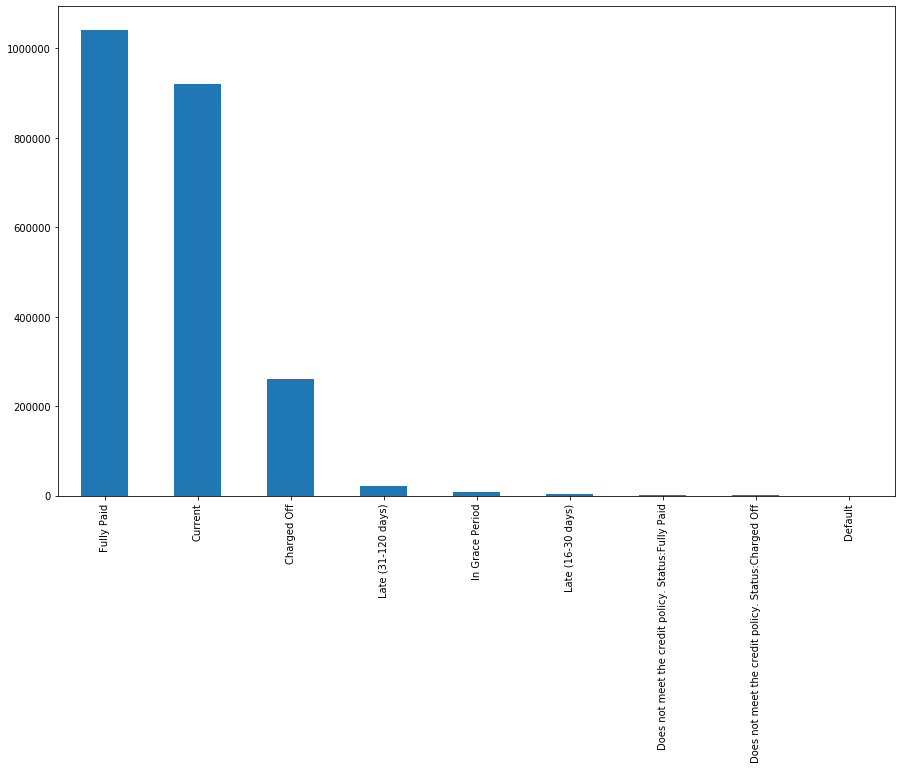

In [0]:
# Investigate labels 
print(data.loan_status.unique())
plt.figure(figsize=(15,9))
pd.value_counts(data.loan_status).plot.bar()
plt.savefig("plots/loan_status.png")

In [0]:
# Remove all rows with "Current"
data.drop(data.loc[(data.loan_status== "Late (31-120 days)") | (data.loan_status == "Current") | (data.loan_status == "Does not meet the credit policy. Status:Fully Paid") | (data.loan_status == "Does not meet the credit policy. Status:Charged Off") | (data.loan_status == "Late (16-30 days)")].index, inplace=True)

In [0]:
# Convert labels to binary class classification problem  (Maybe consider Fully Paid, Late and Default )
data.loc[(data.loan_status == "Fully Paid") | (data.loan_status == "In Grace Period"), "loan_status"] = 1
data.loc[ (data.loan_status=="Default") | (data.loan_status=="Charged Off"),"loan_status"] = 0

In [0]:
# See shape after dropping rows
data.shape

(1312590, 145)

In [0]:
# Counting number of default vs fully paid 
data.loan_status.value_counts()

1    1050904
0     261686
Name: loan_status, dtype: int64

In [0]:
# Peek relabeld dataset 
data.reset_index(drop=True, inplace=True)
data.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,30000,30000,30000.0,36 months,22.35,1151.16,D,D5,Supervisor,5 years,MORTGAGE,100000.0,Source Verified,Dec-2018,1,n,NaN,NaN,debt_consolidation,Debt consolidation,917xx,CA,30.46,0.0,Jan-2012,0.0,51.0,84.0,11.0,1.0,15603,37.0,19.0,w,0.0,0.0,30026.442500,30026.44,30000.0,26.44,0.0,0.0,0.0,Jan-2019,30082.32,NaN,Jan-2019,0.0,NaN,1,Joint App,150000.0,23.38,Source Verified,0.0,0.0,472330.0,1.0,3.0,2.0,2.0,2.0,82850.0,75.0,0.0,1.0,9713.0,60.0,42200.0,1.0,1.0,3.0,4.0,42939.0,15181.0,46.9,0.0,0.0,83.0,73.0,23.0,2.0,1.0,23.0,NaN,8.0,NaN,0.0,3.0,4.0,3.0,5.0,10.0,6.0,8.0,4.0,11.0,0.0,0.0,0.0,2.0,89.5,33.3,1.0,0.0,527120.0,98453.0,28600.0,101984.0,52417.0,Jul-2006,0.0,1.0,16.0,25.2,2.0,15.0,0.0,0.0,70.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,40000,40000,40000.0,60 months,16.14,975.71,C,C4,Assistant to the Treasurer (Payroll),< 1 year,MORTGAGE,45000.0,Verified,Dec-2018,1,n,NaN,NaN,credit_card,Credit card refinancing,456xx,OH,50.53,0.0,Jun-2009,0.0,NaN,NaN,18.0,0.0,34971,64.5,37.0,w,0.0,0.0,40856.678960,40856.68,40000.0,856.68,0.0,0.0,0.0,Feb-2019,40910.48,NaN,Feb-2019,0.0,NaN,1,Joint App,92000.0,35.66,Verified,0.0,0.0,271068.0,2.0,8.0,3.0,4.0,5.0,126749.0,87.0,1.0,1.0,5874.0,75.0,54200.0,4.0,2.0,4.0,5.0,15059.0,14930.0,67.3,0.0,0.0,114.0,70.0,2.0,2.0,1.0,2.0,NaN,9.0,NaN,0.0,7.0,9.0,7.0,7.0,26.0,9.0,10.0,9.0,18.0,0.0,0.0,0.0,4.0,100.0,42.9,0.0,0.0,344802.0,161720.0,45700.0,167965.0,47188.0,Apr-1990,0.0,1.0,32.0,61.1,16.0,19.0,0.0,0.0,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,20000,20000,20000.0,36 months,7.56,622.68,A,A3,Teacher,10+ years,MORTGAGE,100000.0

In [0]:
# Set pandas options
pd.set_option('mode.use_inf_as_na',True)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [0]:
# Investigate Home ownership
data.home_ownership.value_counts()

MORTGAGE    649670
RENT        521508
OWN         140946
ANY            274
OTHER          144
NONE            48
Name: home_ownership, dtype: int64

In [0]:
# See if home ownership has NaN 
data.home_ownership.isna().values.any()

False

In [0]:
# One hot encode home_ownership 
one_hot_encode_home_ownership = pd.get_dummies(data["home_ownership"],prefix="home_ownership")
home_ownership_columns = list(one_hot_encode_home_ownership.columns)

In [0]:
# Concatenate one hot encoded home ownership features
data = pd.concat([data, one_hot_encode_home_ownership],axis=1)

# Drop the original 'home_ownership' column 
data.drop(['home_ownership'],axis=1, inplace=True)

In [0]:
# See if purpose has NaN values
data.purpose.isna().values.any()

False

In [0]:
# One hot encode home_ownership 
one_hot_purpose = pd.get_dummies(data["purpose"],prefix="purpose")
purpose_columns = list(one_hot_purpose.columns)

In [0]:
# Concatenate one hot encoded purpose features
data = pd.concat([data,one_hot_purpose],axis=1)

In [0]:
# Drop the original 'home_ownership' column 
data.drop(['purpose'],axis=1, inplace=True)

In [0]:
# Investigate if dti has any null values 
data.dti.isna().values.any()

# See how many are True
print("Number of NaN dti: {}".format(len(data['dti'].index[data['dti'].apply(np.isnan)])))

Number of NaN dti: 318


In [0]:
# Drop all NaN rows in column dti
data.dropna(subset=["dti"], axis=0, inplace=True)

In [0]:
# Number of Bankrupcies
data.pub_rec_bankruptcies.value_counts()

0.0     1147752
1.0      154047
2.0        7638
3.0        1545
4.0         384
5.0         136
6.0          45
7.0          15
8.0           9
9.0           2
12.0          1
11.0          1
Name: pub_rec_bankruptcies, dtype: int64

In [0]:
# Number of NaN values 
print(data['pub_rec_bankruptcies'].index[data['pub_rec_bankruptcies'].apply(np.isnan)])
print("Number of NaN bankrupcies: {}".format(len(data['pub_rec_bankruptcies'].index[data['pub_rec_bankruptcies'].apply(np.isnan)])))

Int64Index([1275662, 1275714, 1276018, 1279099, 1279373, 1279384, 1279532,
            1279627, 1279660, 1279661,
            ...
            1280363, 1280364, 1280365, 1280366, 1280367, 1280368, 1280369,
            1280370, 1280371, 1280372],
           dtype='int64', length=697)
Number of NaN bankrupcies: 697


In [0]:
# Drop all NaN rows in column pub_rec_bankruptcies
data.dropna(subset=["pub_rec_bankruptcies"], axis=0, inplace=True)

In [0]:
# Investigate NaN values for emp_length
# print(data['emp_length'].index[data['emp_length'].isna()])
# print("Number of NaN emp_length: {}".format(len(data['emp_length'].index[data['emp_length'].isna()])))

In [0]:
# Transform emp_length into label encoded 
# data["emp_length"].head(5)
# emp_length_encoder  = LabelEncoder() 
# emp_length_encoder.fit(["< 1 year", "1 year","2 years","3 years","4 years","5 years","6 years","7 years","8 years","9 years", "10+ years"]) 
# data["emp_length"] = emp_length_encoder.transform(data["emp_length"]) 
# data["emp_length"].head(5)

# CREATE A NEW CATEGORY NaN so that we can still use emp_length 

In [0]:
# Drop data that will not be used 
data.drop(columns=["id", "member_id","url", "desc", "grade"], inplace=True)

In [0]:
# Fill all N/A with 0 
data.settlement_amount.fillna(value=0, inplace=True)

In [0]:
# Verify all NaN has been patched with 0 
print(data.settlement_amount.value_counts())
print(data['settlement_amount'].index[data['settlement_amount'].apply(np.isnan)])
print("Number of NaN Settlement Amount: {}".format(len(data['settlement_amount'].index[data['settlement_amount'].apply(np.isnan)])))

0.00        1279579
5000.00          63
4000.00          50
6000.00          49
3000.00          49
8000.00          44
10000.00         44
7000.00          40
3500.00          39
6500.00          34
7500.00          33
9000.00          33
4500.00          31
2000.00          29
2500.00          29
5500.00          26
1500.00          24
4200.00          24
12000.00         23
2800.00          20
4800.00          18
3200.00          18
11000.00         17
1200.00          17
15000.00         17
2400.00          16
3600.00          16
3800.00          16
2100.00          15
1800.00          15
4700.00          15
8500.00          14
5800.00          14
1000.00          14
2600.00          13
2300.00          13
3300.00          13
4300.00          13
11500.00         13
5200.00          13
800.00           13
13000.00         12
8400.00          12
5400.00          11
2200.00          11
14000.00         11
5700.00          11
6800.00          11
3700.00          11
1900.00          11


In [0]:
# Remove months in term column and encode 36 as 0, 60 as 1
data["term"] = data["term"].apply(lambda x: 0 if int(x.split()[0]) == 36 else 1)

In [0]:
# Encode values using Label Encoder 
sub_grade_encoder  = LabelEncoder() 
# Transform all sub_grade to labels 
data["sub_grade"] = sub_grade_encoder.fit_transform(data["sub_grade"]) 

In [0]:
# Label encoding using Pandas 
data["verification_status"] = data["verification_status"].astype('category').cat.codes

In [0]:
# Drop all NaN rows in column revol_util
data.dropna(subset=["revol_util"], axis=0, inplace=True)

In [0]:
# Transform emp_title to one hot encoded labels (dataset is too big, session always crashes)
# data["emp_title"] = data["emp_title"].apply(lambda x: str(x).upper())# put all employee title to upper case
# See if emp_title has NaN values
# data.emp_title.isna().values.any()

In [0]:
data.head(100)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_title,emp_length,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,30000,30000,30000.0,0,22.35,1151.16,19,Supervisor,5 years,100000.00,1,Dec-2018,1,n,Debt consolidation,917xx,CA,30.46,0.0,Jan-2012,0.0,51.0,84.0,11.0,1.0,15603,37.0,19.0,w,0.00,0.00,30026.442500,30026.44,30000.00,26.44,0.0,0.0,0.0,Jan-2019,30082.32,NaN,Jan-2019,0.0,NaN,1,Joint App,150000.0,23.38,Source Verified,0.0,0.0,472330.0,1.0,3.0,2.0,2.0,2.0,82850.0,75.0,0.0,1.0,9713.0,60.0,42200.0,1.0,1.0,3.0,4.0,42939.0,15181.0,46.9,0.0,0.0,83.0,73.0,23.0,2.0,1.0,23.0,NaN,8.0,NaN,0.0,3.0,4.0,3.0,5.0,10.0,6.0,8.0,4.0,11.0,0.0,0.0,0.0,2.0,89.5,33.3,1.0,0.0,527120.0,98453.0,28600.0,101984.0,52417.0,Jul-2006,0.0,1.0,16.0,25.2,2.0,15.0,0.0,0.0,70.0,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,0.0,NaN,NaN,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,40000,40000,40000.0,1,16.14,975.71,13,Assistant to the Treasurer (Payroll),< 1 year,45000.00,2,Dec-2018,1,n,Credit card refinancing,456xx,OH,50.53,0.0,Jun-2009,0.0,NaN,NaN,18.0,0.0,34971,64.5,37.0,w,0.00,0.00,40856.678960,40856.68,40000.00,856.68,0.0,0.0,0.0,Feb-2019,40910.48,NaN,Feb-2019,0.0,NaN,1,Joint App,92000.0,35.66,Verified,0.0,0.0,271068.0,2.0,8.0,3.0,4.0,5.0,126749.0,87.0,1.0,1.0,5874.0,75.0,54200.0,4.0,2.0,4.0,5.0,15059.0,14930.0,67.3,0.0,0.0,114.0,70.0,2.0,2.0,1.0,2.0,NaN,9.0,NaN,0.0,7.0,9.0,7.0,7.0,26.0,9.0,10.0,9.0,18.0,0.0,0.0,0.0,4.0,100.0,42.9,0.0,0.0,344802.0

In [0]:
# Investigate NaN values 
columns_NaN =  ["inq_fi","mo_sin_old_rev_tl_op","mo_sin_rcnt_rev_tl_op","percent_bc_gt_75"]
for _ in columns_NaN:
  print(data[_].index[data[_].isna()])
  print("Number of NaN {}: {}".format(_,len(data[_].index[data[_].isna()])))

In [0]:
# Desired columns
desired_columns = ["loan_amnt","verification_status", "revol_util", "term","dti", "int_rate", "installment", "sub_grade", "annual_inc", "delinq_2yrs", "revol_bal", "total_acc", "pub_rec_bankruptcies", "tax_liens"] + home_ownership_columns + purpose_columns

In [0]:
# Standardize desired columns 
standard_scaler = StandardScaler()
data[desired_columns] = standard_scaler.fit_transform(data[desired_columns])  

In [0]:
# Normalize desired columns 
normalize_scaler = MinMaxScaler()
data[desired_columns] = normalize_scaler.fit_transform(data[desired_columns]) 

In [0]:
print("Training set size: {}".format(data.shape))

Training set size: (1336318, 158)


In [0]:
# Final dataset
y = data.loan_status
X = data[desired_columns].reset_index(drop=True)

In [0]:
print(y.shape)
print(X.shape)

(1310761,)
(1310761, 34)


In [0]:
# Save training data
X.to_csv("data/X.csv", index=False)

In [0]:
# Save target data
y.to_csv("data/y.csv", header=True,index=False)

In [0]:
# Verify if there are any NaN or inf values 
print("Null columns")
for column in X.columns:
  print("{}: {}".format(column, X[column].isna().values.any()))
print("{} features".format(len(X.columns)))

Null columns
loan_amnt: False
verification_status: False
revol_util: False
term: False
dti: False
int_rate: False
installment: False
sub_grade: False
annual_inc: False
delinq_2yrs: False
revol_bal: False
total_acc: False
pub_rec_bankruptcies: False
tax_liens: False
home_ownership_ANY: False
home_ownership_MORTGAGE: False
home_ownership_NONE: False
home_ownership_OTHER: False
home_ownership_OWN: False
home_ownership_RENT: False
purpose_car: False
purpose_credit_card: False
purpose_debt_consolidation: False
purpose_educational: False
purpose_home_improvement: False
purpose_house: False
purpose_major_purchase: False
purpose_medical: False
purpose_moving: False
purpose_other: False
purpose_renewable_energy: False
purpose_small_business: False
purpose_vacation: False
purpose_wedding: False
34 features


In [0]:
# Display complete feature data
X.head(5)

,loan_amnt,verification_status,revol_util,term,dti,int_rate,installment,sub_grade,annual_inc,delinq_2yrs,revol_bal,total_acc,pub_rec_bankruptcies,tax_liens,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,1.786101,-0.016461,-0.609031,-0.566448,1.111417,1.905043,2.726419,1.280382,0.340129,-0.362275,-0.028866,-0.501616,2.287145,-0.130619,-0.014433,1.010085,-0.005859,-0.010409,-0.346822,-0.811905,-0.104525,-0.529705,0.848436,-0.015256,-0.2632,-0.073332,-0.148967,-0.107977,-0.084148,-0.246783,-0.026401,-0.107814,-0.081983,-0.041679
1,2.934168,1.260931,0.513284,1.765388,2.942362,0.602071,2.054992,0.350934,-0.445945,-0.362275,0.839557,0.998600,-0.356245,-0.130619,-0.014433,1.010085,-0.005859,-0.010409,-0.346822,-0.811905,-0.104525,1.887842,-1.178640,-0.015256,-0.2632,-0.073332,-0.148967,-0.107977,-0.084148,-0.246783,-0.026401,-0.107814,-0.081983,-0.041679
2,0.638034,-1.293853,-0.898792,-0.566448,0.058647,-1.198172,0.703985,-1.353056,0.340129,-0.362275,0.411129,-0.501616,-0.356245,-0.130619,-0.014433,1.010085,-0.005859,-0.010409,-0.346822,-0.811905,-0.104525,1.887842,-1.178640,-0.015256,-0.2632,-0.073332,-0.148967,-0.107977,-0.084148,-0.246783,-0.026401,-0.107814,-0.081983,-0.041679
3,-1.141471,-1.293853,-1.494640,-0.566448,-1.244088,-0.411352,-1.112600,-0.578515,-0.538844,-0.362275,-0.527959,-0.001544,-0.356245,-0.130619,-0.014433,-0.990015,-0.005859,-0.010409,-0.346822,1.231672,-0.104525,1.887842,-1.178640,-0.015256,-0.2632,-0.073332,-0.148967,-0.107977,-0.084148,-0.246783,-0.026401,-0.107814,-0.081983,-0.041679
4,-0.690854,1.260931,0.562257,-0.566448,-0.538896,2.937350,-0.357976,2.054923,5.342415,-0.362275,0.922103,0.998600,-0.356245,-0.130619,-0.014433,1.010085,-0.005859,-0.010409,-0.346822,-0.811905,-0.104525,1.887842,-1.178640,-0.015256,-0.2632,-0.073332,-0.148967,-0.107977,-0.084148,-0.246783,-0.026401,-0.107814,-0.081983,-0.041679


In [0]:
# Describe features 
X.describe(include='all')

,loan_amnt,verification_status,revol_util,term,dti,int_rate,installment,sub_grade,annual_inc,delinq_2yrs,revol_bal,total_acc,pub_rec_bankruptcies,tax_liens,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
count,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06,1.310761e+06
mean,6.440799e-15,-4.954258e-15,6.710016e-15,-4.873133e-13,3.030184e-16,4.014333e-14,3.101254e-15,-9.401588e-15,9.214919e-15,1.802867e-13,-1.032303e-15,3.201459e-15,7.468845e-14,3.838831e-13,7.734072e-14,2.663971e-15,3.957043e-14,2.915000e-13,-3.763738e-13,-1.229658e-13,-9.815107e-14,4.368335e-14,-1.519736e-13,-4.341511e-14,-4.173416e-13,1.496457e-14,1.416476e-13,-3.358289e-14,1.530961e-14,2.496433e-13,1.160430e-14,2.966069e-13,6.060050e-14,-5.068722e-13
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.600698e+00,-1.293853e+00,-2.119055e+00,-5.664477e-01,-1.758613e+00,-1.670263e+00,-1.660075e+00,-1.662872e+00,-1.088867e+00,-3.622751e-01,-7.284743e-01,-1.918488e+00,-3.562451e-01,-1.306193e-01,-1.443327e-02,-9.900152e-01,-5.859384e-03,-1.040893e-02,-3.468221e-01,-8.119046e-01,-1.045253e-01,-5.297054e-01,-1.178640e+00,-1.525593e-02,-2.631996e-01,-7.333188e-02,-1.489674e-01,-1.079767e-01,-8.414758e-02,-2.467827e-01,-2.640128e-02,-1.078139e-01,-8.198260e-02,-4.167877e-02
25%,-7.396472e-01,-1.293853e+00,-7.477901e-01,-5.664477e-01,-5.908957e-01,-7.386692e-01,-7.248982e-01,-7.334231e-01,-4.316526e-01,-3.622751e-01,-4.612844e-01,-7.516525e-01,-3.562451e-01,-1.306193e-01,-1.443327e-02,-9.900152e-01,-5.859384e-03,-1.040893e-02,-3.468221e-01,-8.119046e-01,-1.045253e-01,-5.297054e-01,-1.178640e+00,-1.525593e-02,-2.631996e-01,-7.333188e-02,-1.489674e-01,-1.079767e-01,-8.414758e-02,-2.467827e-01,-2.640128e-02,-1.078139e-01,-8.198260e-02,-4.167877e-02
50%,-2.804203e-01,-1.646099e-02,1.538388e-02,-5.664477e-01,-5.994926e-02,-1.008212e-01,-2.419832e-01,-1.137907e-01,-1.600999e-01,-3.622751e-01,-2.286198e-01,-1.682349e-01,-3.562451e-01,-1.306193e-01,-1.443327e-02,-9.900152e-01,-5.859384e-03,-1.040893e-02,-3.468221e-01,-8.119046e-01,-1.045253e-01,-5.297054e-01,8.484355e-01,-1.525593e-02,-2.631996e-01,-7.333188e-02,-1.489674e-01,-1.079767e-01,-8.414758e-02,-2.467827e-01,-2.640128e-02,-1.078139e-01,-8.198260e-02,-4.167877e-02
75%,6.380336e-01,1.260931e+00,7.703956e-01,-5.664477e-01,5.275585e-01,5.747941e-01,5.451312e-01,6.607499e-01,1.972062e-01,-3.622751e-01,1.574356e-01,5.818734e-01,-3.562451e-01,-1.306193e-01,-1.443327e-02,1.010085e+00,-5.859384e-03,-1.040893e-02,-3.468221e-01,1.231672e+00,-1.045253e-01,-5.297054e-01,8.484355e-01,-1.525593e-02,-2.631996e-01,-7.333188e-02,-1.489674e-01,-1.079767e-01,-8.414758e-02,-2.467827e-01,-2.640128e-02,-1.078139e-01,-8.198260e-02,-4.167877e-02
max,2.934168e+00,1.260931e+00,3.429700e+01,1.765388e+00,8.946931e+01,3.717874e+00,4.902656e+00,3.604004e+00,1.561142e+02,4.406140e+01,1.295187e+02,1.258361e+01,3.136443e+01,2.128181e+02,6.928436e+

#Data Vizualization 

loan_amnt
term
int_rate
installment
sub_grade
annual_inc
delinq_2yrs
revol_bal
total_acc
pub_rec_bankruptcies
tax_liens
home_ownership_ANY
home_ownership_MORTGAGE
home_ownership_NONE
home_ownership_OTHER
home_ownership_OWN
home_ownership_RENT


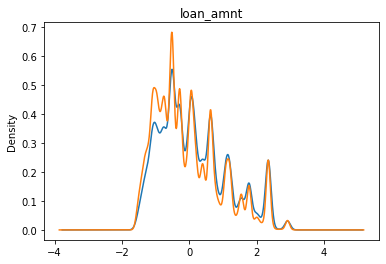

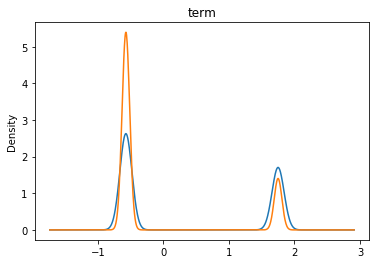

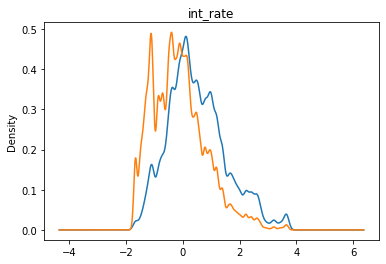

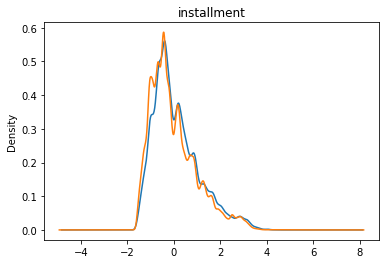

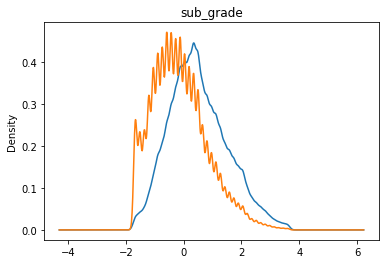

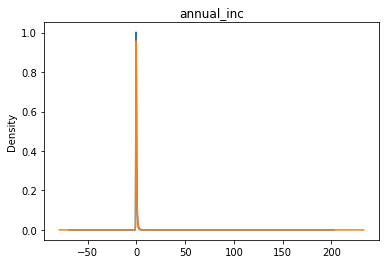

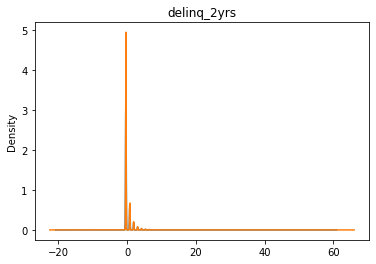

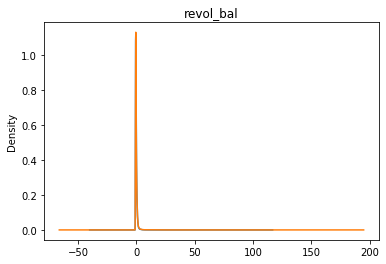

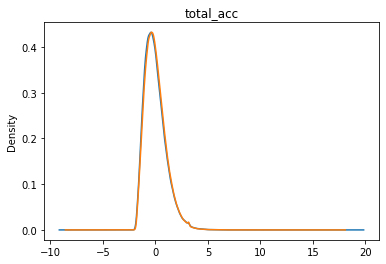

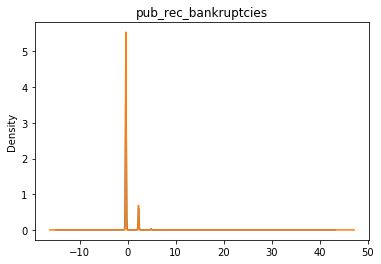

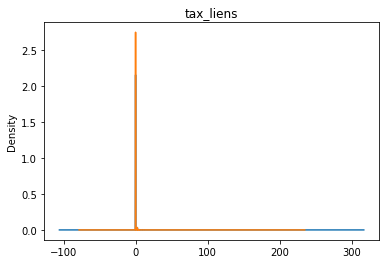

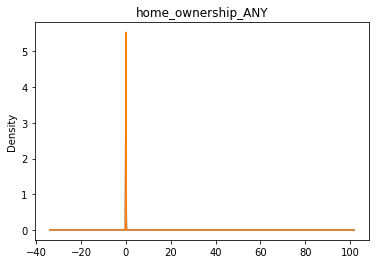

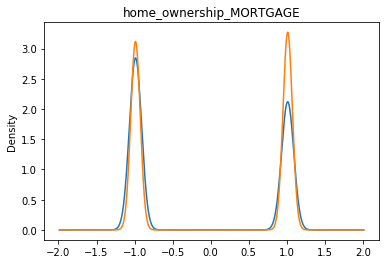

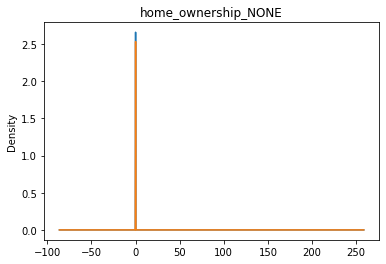

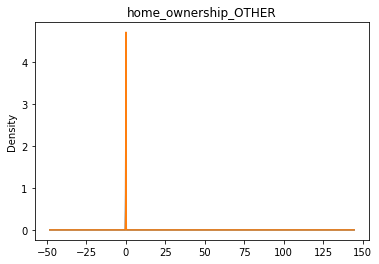

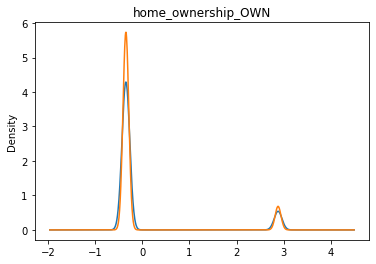

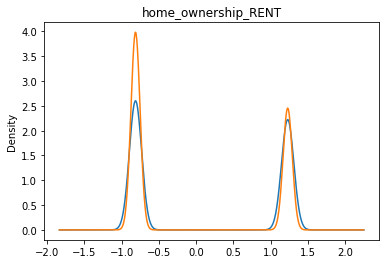

In [0]:
# Generate Kernel Density Estimate for each attribute per loan status
for x in data[desired_columns].columns:
  print(x)
  fig, ax = plt.subplots()
  plt.title(x)
  data.groupby("loan_status")[x].plot.kde()

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

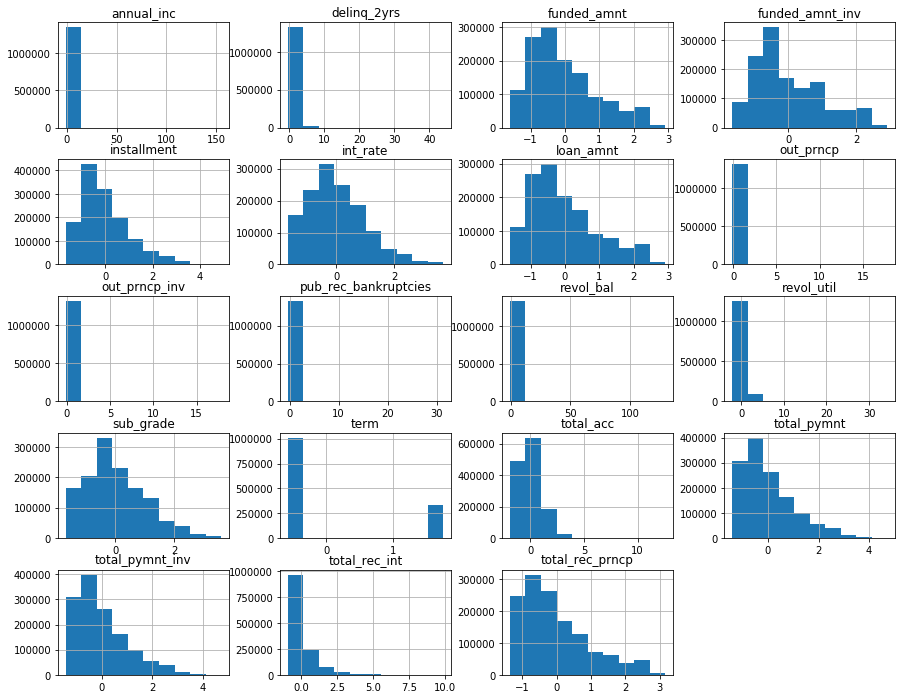

In [0]:
# Group values into buckets and review the frequency in each bucket as histograms.
X.hist(figsize=(15,12))

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19]), <a list of 19 Text xticklabel objects>)

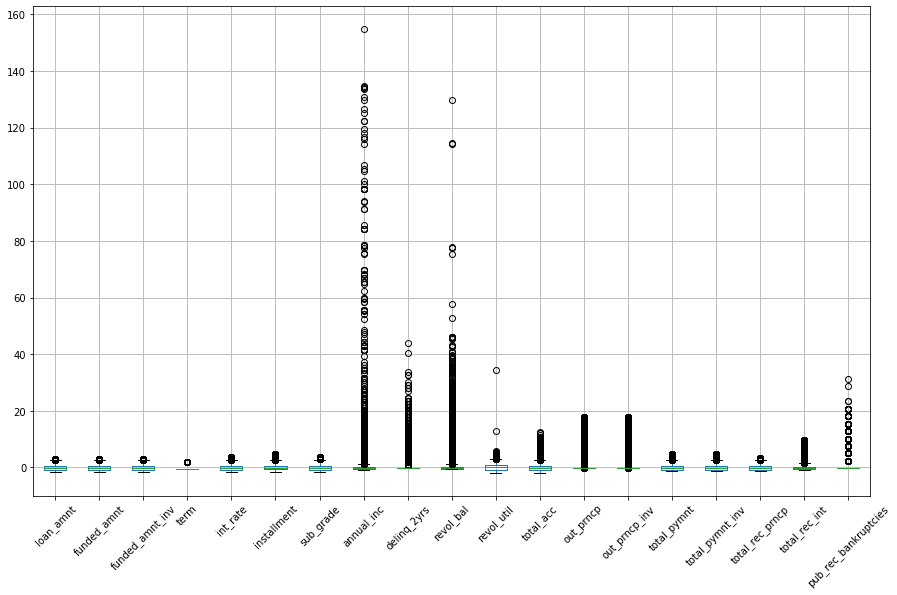

In [0]:
# Review the spread of each attribute by looking at box and whisker plots
plt.figure(figsize=(20,9))
X.boxplot()
plt.xticks(rotation=45)

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

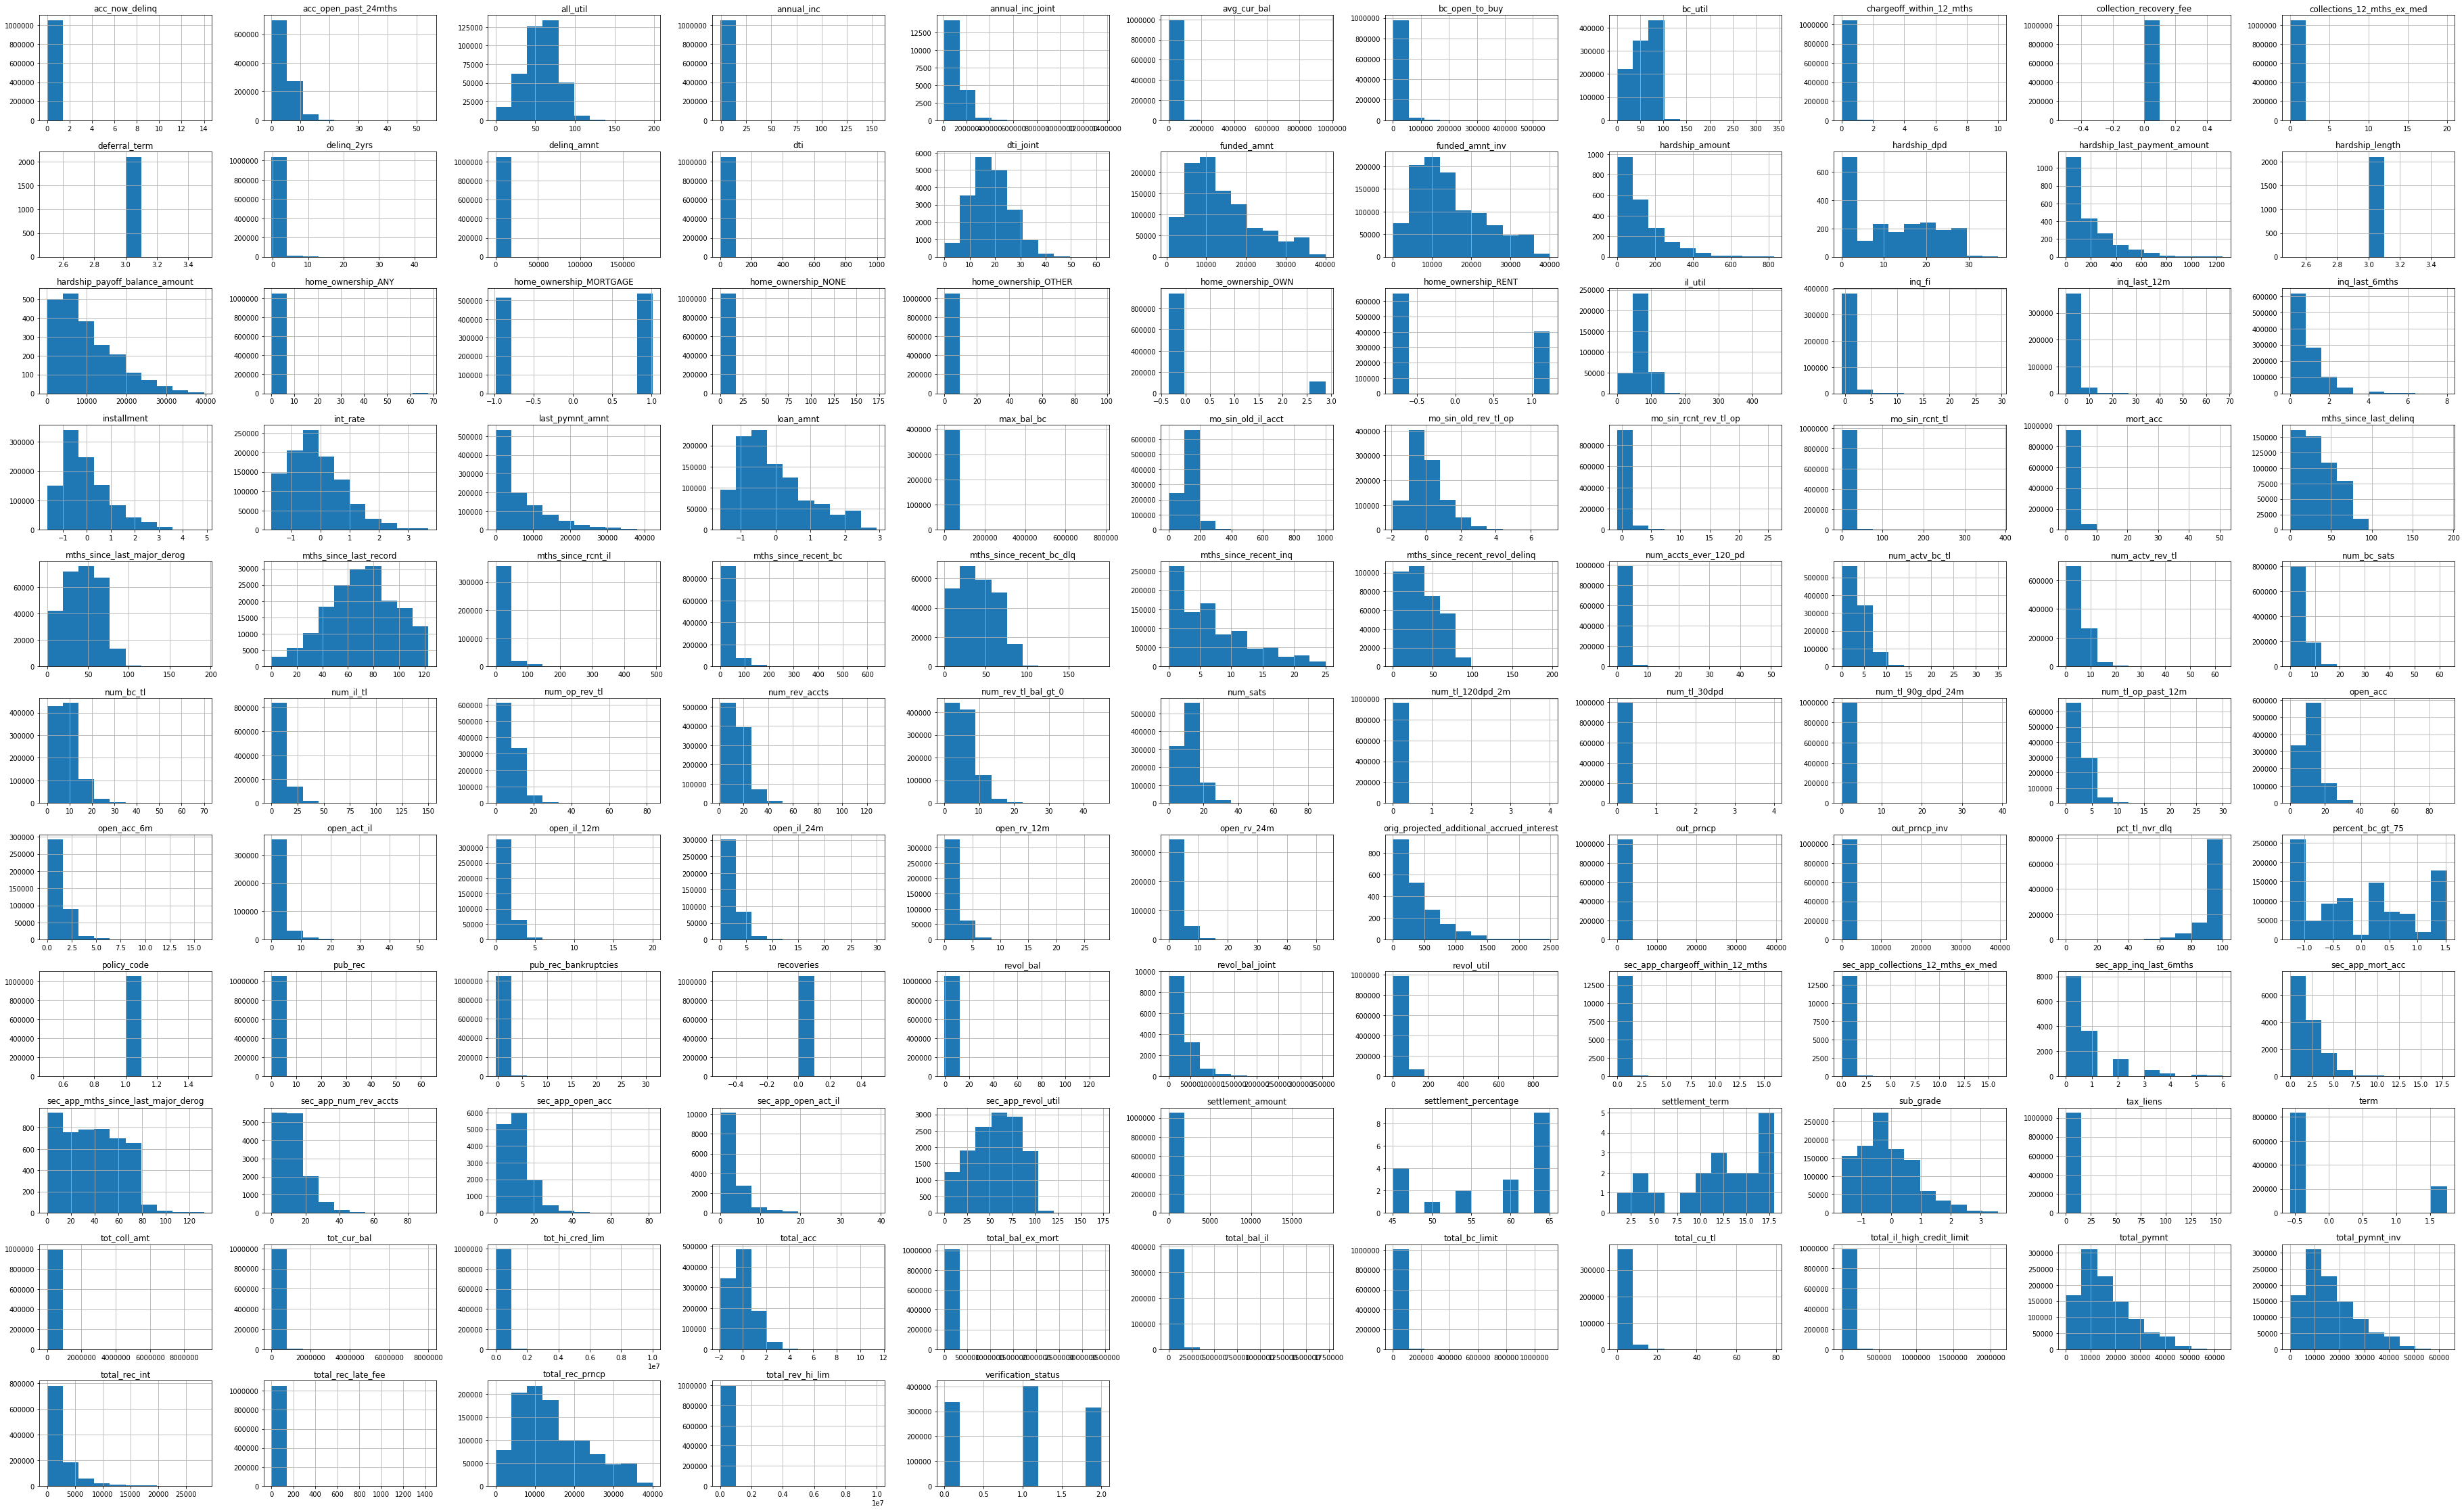

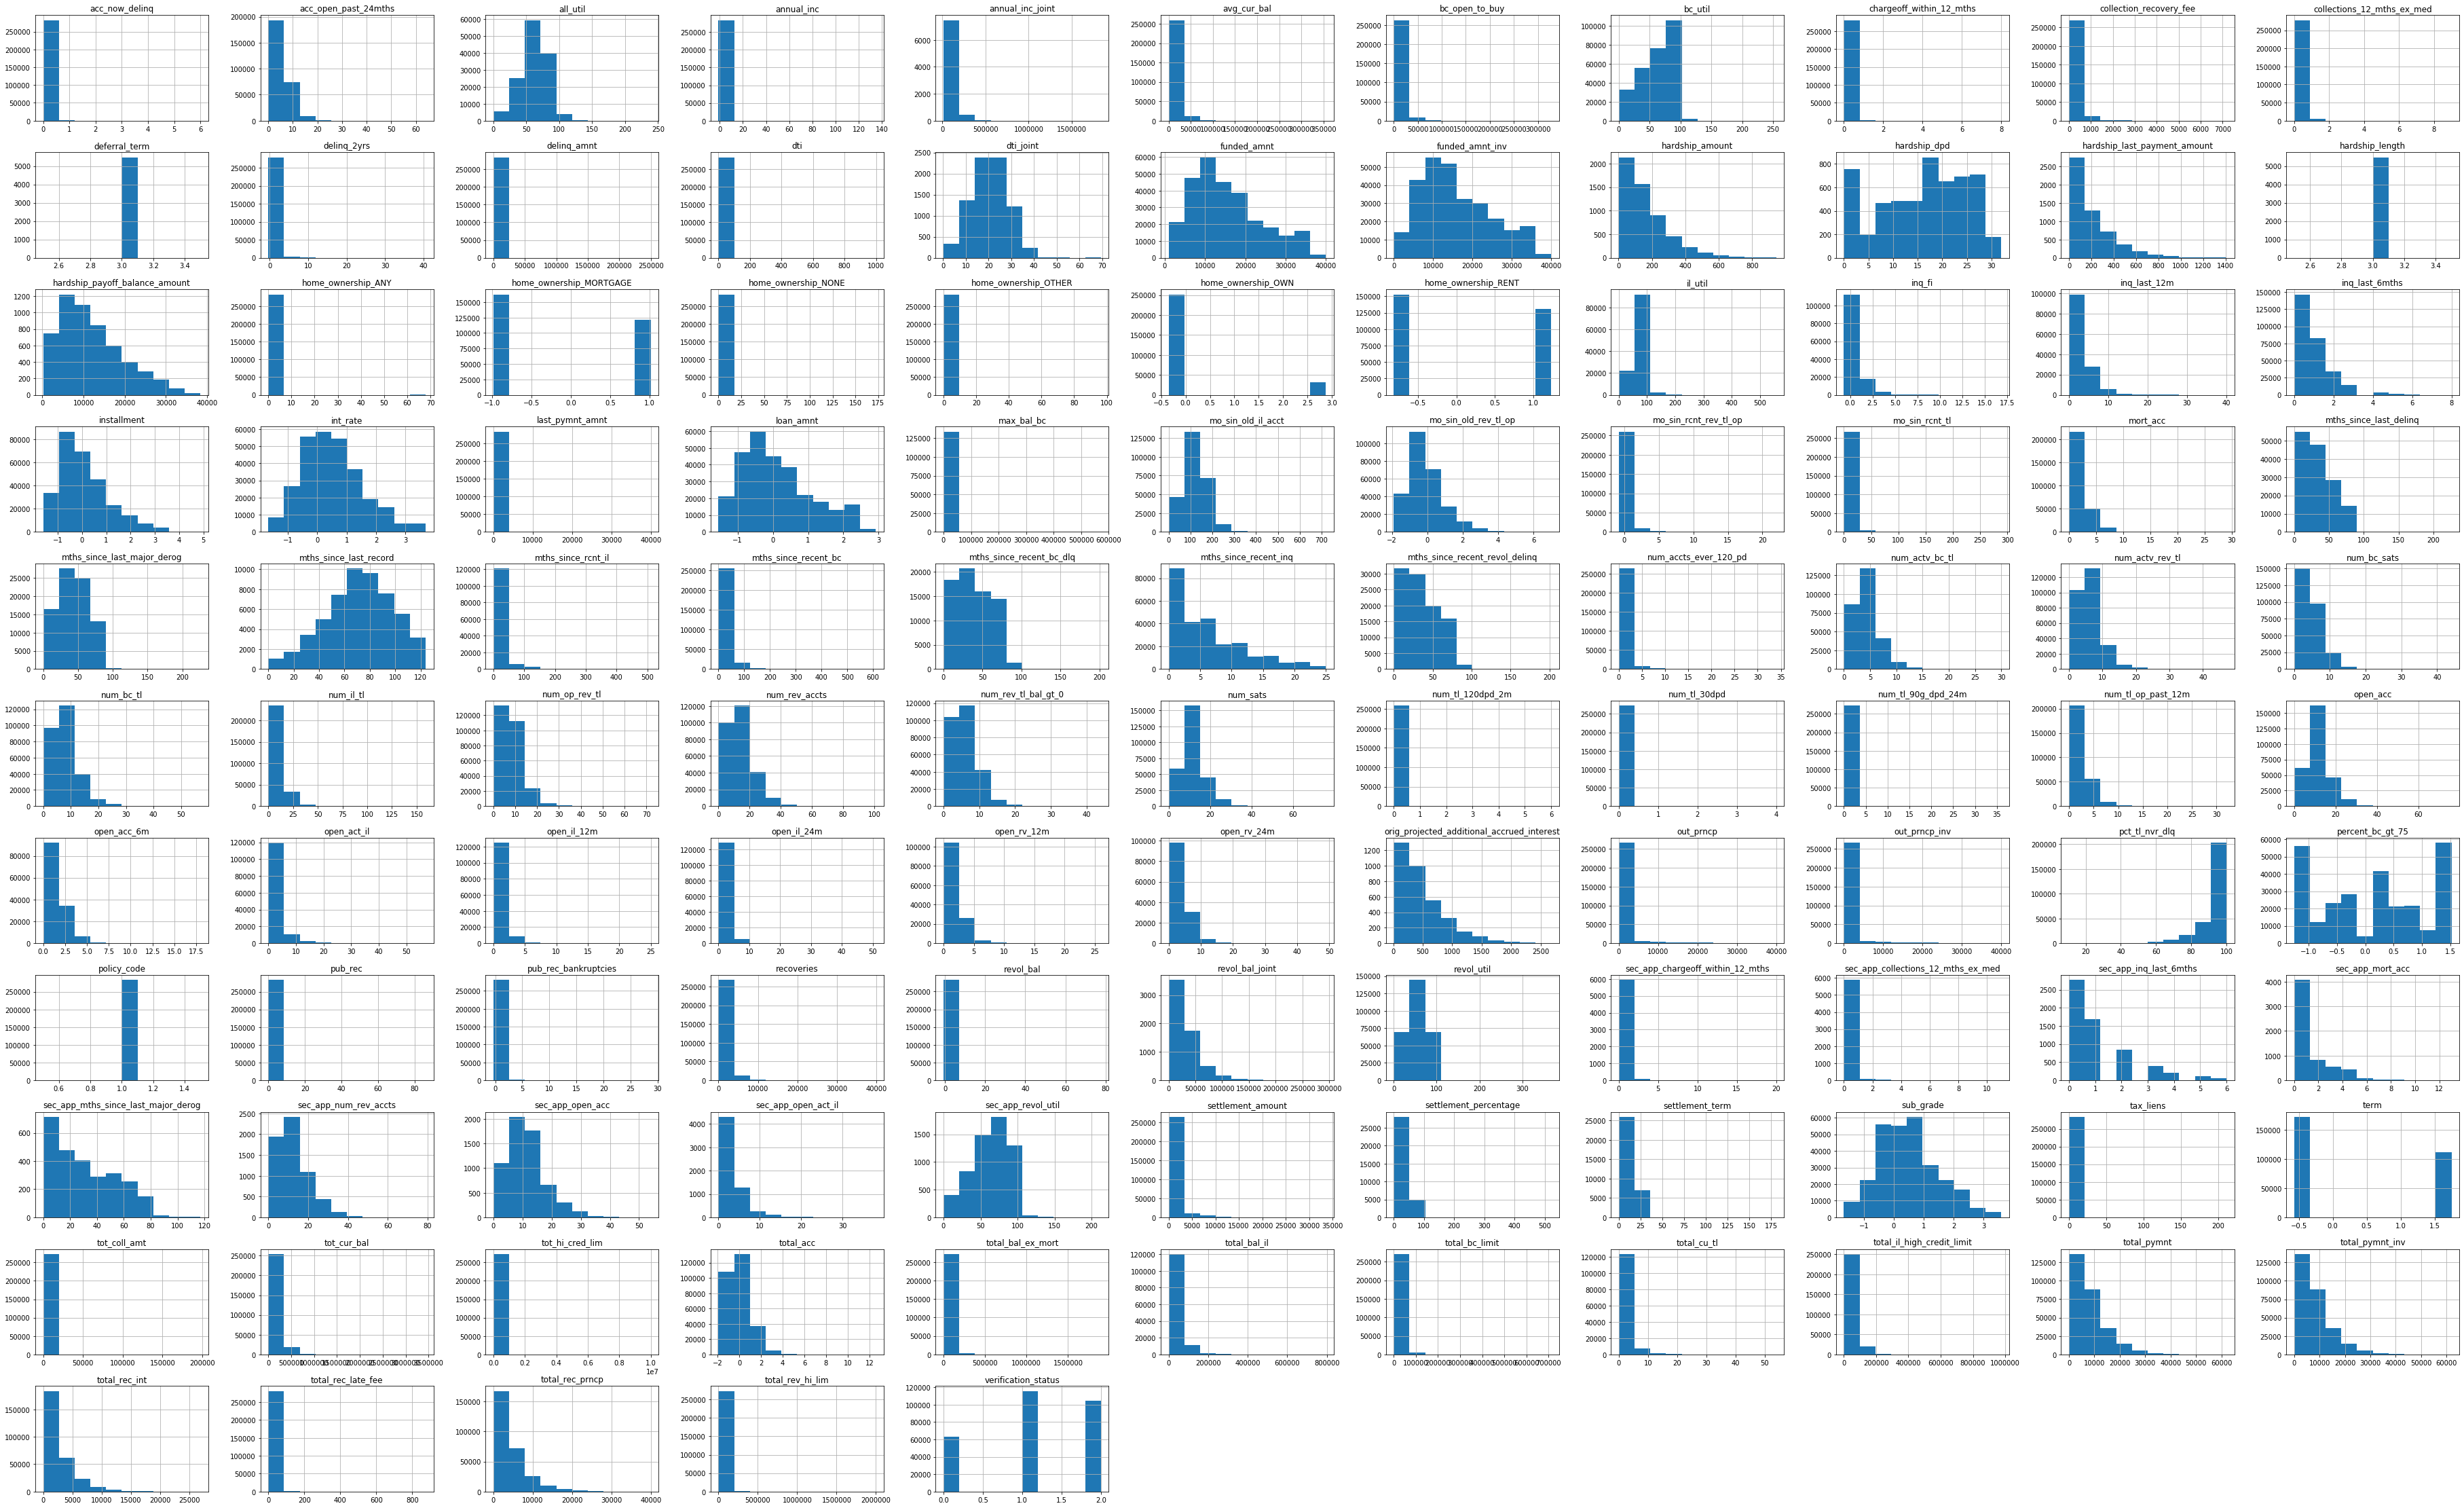

In [0]:
# Investigate difference between the distribution of attributes from default and full paid 
data.groupby('loan_status').hist(figsize=(64,40))
plt.xticks(rotation=45)

loan_status
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: hardship_payoff_balance_amount, dtype: object

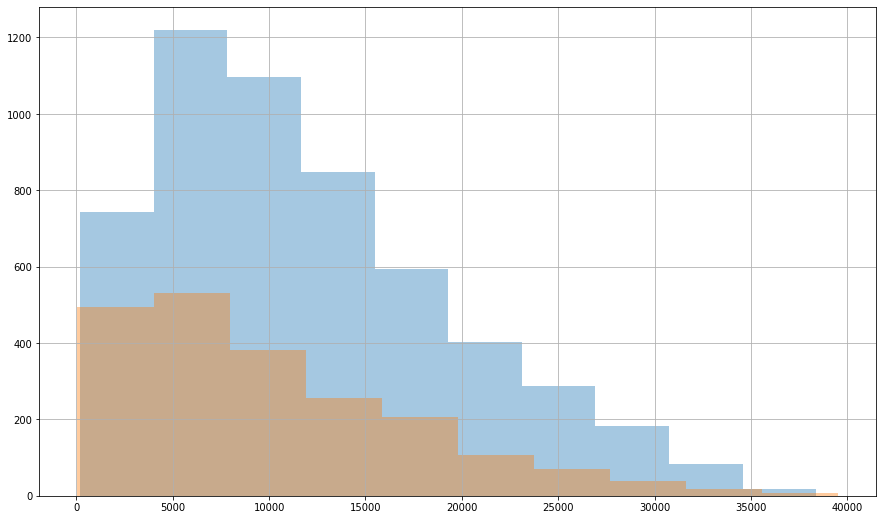

In [0]:
# Investigate Specific Feature 
data.groupby('loan_status').hardship_payoff_balance_amount.hist(alpha=0.4, figsize=(15,9))

In [0]:
# Explore relationships between the attributes. This allows to see if there are correlations between the variables 
from pandas.plotting import scatter_matrix
scatter_matrix(data, alpha=0.2, figsize=(100, 100), diagonal='kde')

# Feature Engineering

#Model Selection

In [0]:
# Models 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Model Selection
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Utilities
import pickle 

In [0]:
# Read preprocessed training data 
X = pd.read_csv("data/X.csv")
y = pd.read_csv("data/y.csv")

In [0]:

# Splitting data for validation
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2)

In [0]:
# Create models 
sgd_clf = SGDClassifier()
svc = SVC(kernel='rbf')
log_reg = LogisticRegression(class_weight="balanced")
rf = RandomForestClassifier(n_estimators = 100, max_depth=3)
lda = LinearDiscriminantAnalysis(solver='svd')

In [0]:
# LDA 
f1_scores = cross_val_score(estimator=lda, X=X,  y=y, cv=5, scoring='f1',n_jobs=-1)
precision_scores = cross_val_score(estimator=lda, X=X,  y=y, cv=5, scoring='precision',n_jobs=-1)
recall_scores = cross_val_score(estimator=lda, X=X,  y=y, cv=5, scoring='recall',n_jobs=-1)
print("LDA Testing Scores \nF1-score: {}\nPrecision: {}\nRecall: {}".format(f1_scores,precision_scores,recall_scores))

LDA Testing Scores 
F1-score: [0.8770801  0.88061048 0.87519945 0.87278277 0.87745202]
Precision: [0.79944908 0.80273637 0.79902674 0.80024464 0.80218924]
Recall: [0.97140945 0.97521709 0.96742598 0.95978218 0.96829956]


In [0]:
# Logistic Regression
f1_scores = cross_val_score(estimator=log_reg, X=X,  y=y, cv=5, scoring='f1',n_jobs=-1)
precision_scores = cross_val_score(estimator=log_reg, X=X,  y=y, cv=5, scoring='precision',n_jobs=-1)
recall_scores = cross_val_score(estimator=log_reg, X=X,  y=y, cv=5, scoring='recall',n_jobs=-1)
print("Logistic Regression Testing Scores \nF1-score: {}\nPrecision: {}\nRecall: {}".format(f1_scores,precision_scores,recall_scores))

Logistic Regression Testing Scores 
F1-score: [0.76475057 0.76023451 0.75563073 0.76364143 0.74301063]
Precision: [0.8604244  0.87003133 0.8712948  0.85654245 0.87047181]
Recall: [0.68822432 0.67504475 0.66707655 0.68892075 0.64810946]


In [0]:
# Random Forest
f1_scores = cross_val_score(estimator=rf, X=X,  y=y, cv=5, scoring='f1',n_jobs=-1)
precision_scores = cross_val_score(estimator=rf, X=X,  y=y, cv=5, scoring='precision',n_jobs=-1)
recall_scores = cross_val_score(estimator=rf, X=X,  y=y, cv=5, scoring='recall',n_jobs=-1)
print("Random Forest Testing Scores \nF1-score: {}\nPrecision: {}\nRecall: {}".format(f1_scores,precision_scores,recall_scores))

Random Forest Testing Scores 
F1-score: [0.88148836 0.88149021 0.88148971 0.88148971 0.88148971]
Precision: [0.78809047 0.78809342 0.78809263 0.78809263 0.78809263]
Recall: [1. 1. 1. 1. 1.]


In [0]:
# Support Vector Machines  
f1_scores = cross_val_score(estimator=rf, X=X,  y=y, cv=5, scoring='f1',n_jobs=-1)
precision_scores = cross_val_score(estimator=rf, X=X,  y=y, cv=5, scoring='precision',n_jobs=-1)
recall_scores = cross_val_score(estimator=rf, X=X,  y=y, cv=5, scoring='recall',n_jobs=-1)
print("Support Vector Machines Testing Scores \nF1-score: {}\nPrecision: {}\nRecall: {}".format(f1_scores,precision_scores,recall_scores))

Support Vector Machines Testing Scores 
F1-score: [0.88148836 0.88149021 0.88148971 0.88148971 0.88148971]
Precision: [0.78809047 0.78809342 0.78809263 0.78809263 0.78809263]
Recall: [1. 1. 1. 1. 1.]


In [0]:
# Run GridSearchCV for best parameters
log_reg_hyperparams = {'solver':('liblinear','sag', 'saga'), 'C':[0.01,0.1,1], "max_iter":[100, 1000,3000] } 
sgd_clf_hyperparams = {'loss':('hinge','log', 'modified_huber', 'squared_hinge'), "max_iter":[100, 1000,3000], "penalty" :['l2'], "alpha":[0.0001, 1], "max_iter":[100, 1000], "tol":[1e-3, 1e-2], "eta0":[1e-3],"class_weight":("balanced",), "shuffle":(True,), "early_stopping":(True,), "learning_rate":('constant', 'optimal', "invscaling",'adaptive'), "validation_fraction":[0.2], "n_iter_no_change":[5]} 
clf = GridSearchCV(estimator=sgd_clf, param_grid=sgd_clf_hyperparams, scoring="f1", n_jobs=-1, cv=5, verbose=1)
clf.fit(X,y)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed: 34.8min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validati...
                         'early_stopping': (True,), 'eta0': [0.001],
                         'learning_rate': ('constant', 'optimal', 'invscaling',
                                           'adaptive'),
                         'loss': ('hinge', 'log', 'modified_huber',
                                  'squared_h

In [0]:
# Log results from GridSearchCV
print("Best Estimator: {}\nBest parameters: {}\nBest scores: {}".format(clf.best_estimator_, clf.best_params_, clf.best_score_))

Best Estimator: SGDClassifier(alpha=1, average=False, class_weight='balanced',
              early_stopping=True, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='constant', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.2, verbose=0, warm_start=False)
Best parameters: {'alpha': 1, 'class_weight': 'balanced', 'early_stopping': True, 'eta0': 0.001, 'learning_rate': 'constant', 'loss': 'hinge', 'max_iter': 1000, 'n_iter_no_change': 5, 'penalty': 'l2', 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.2}
Best scores: 0.7989458064500928


In [0]:
# Optimized SGDClassifier
sgd = SGDClassifier(alpha=1, average=False, class_weight='balanced',
              early_stopping=True, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='constant', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.2, verbose=0, warm_start=False)

In [0]:
# Create optimized log reg model 
log_reg = LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# Train final Logistic Regression Model optimized for Precision 
log_reg.fit(X,y)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# Save model 
# pickle.dump(svc, open("models/logistic_regression.pkl", "wb"))
pickle.dump(log_reg, open("models/logistic_regression.pkl", "wb"))
# pickle.dump(rf, open("models/logistic_regression.pkl", "wb"))
# pickle.dump(lda, open("models/logistic_regression.pkl", "wb"))

#Predict

In [0]:
# Read dataset
X_test = pd.read_csv(r"data/current_loans.csv")

In [0]:
log_reg = pickle.load(open("models/logistic_regression.pkl", 'rb'))

In [0]:
# Probability of fully paid 
fully_paid_probs = log_reg.predict_proba(X_test)

In [0]:
# Default probability for current loans 
default_probs = [ _[0] for _ in fully_paid_probs]

In [0]:
print((sum(default_probs)/len(default_probs)))

0.46583849605259364


#XGBoost
##Boosting
Boosting is an ensemble method. XGBoost is known for its performance with unbalanced datasets

In [0]:
import xgboost as xgb

#Deep Learning

In [0]:
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, Dropout
from keras.optimizers import SGD 

In [0]:
# Create model
def create_model():
  model = Sequential()
  model.add(Dense(34, activation='relu'))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']) # try binary_accuracy
  return model 

In [0]:
from sklearn.utils import class_weight

# Create imbalanced class weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y.loan_status),y.loan_status)

In [0]:
# Deploy Neural Network Model 
model = create_model()
model.fit(x=X.values,y=y.loan_status.values, batch_size=5000, epochs=30,shuffle=True, class_weight=class_weights, validation_split=0.2, use_multiprocessing=True)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


ValueError: ignored

TODO List:
- Consult Kaggle competitions (feature selection, models, etc.)
- Save graphs
- Kelvin?
- Are data obtain before or after loan, what are columns that are available for current, if those data come after loan, then it already contains the true results in it 
- Oversampling/Undersampling
- Ensemble different resampled datasets
- cross-validation should be applied properly while using over-sampling method to address imbalance problems.
https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html